In [1]:
import sys 
import os
sys.path.append(os.path.abspath("/Users/mouginot/work/helpmetric"))
import cymetrichelper as cyh
import pandahelper as pdh


import cymetric as cym
import pandas as pd

import numpy as np

import matplotlib.pyplot as plt
from cymetric import graphs as cgr
from cymetric import timeseries as tm

%matplotlib inline

/opt/local/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/importlib/_bootstrap.py:222: QAWarning: pyne.data is not yet QA compliant.
  return f(*args, **kwds)
/opt/local/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/importlib/_bootstrap.py:222: QAWarning: pyne.material is not yet QA compliant.
  return f(*args, **kwds)
/opt/local/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/importlib/_bootstrap.py:222: QAWarning: pyne.enrichment is not yet QA compliant.
  return f(*args, **kwds)


In [2]:
from cymetric.tools import format_nucs, reduce, merge, add_missing_time_step
def SWU(evaler, facilities=()):
    """
    Shape the reduced SWU Data Frame. Applying nuclides/facilities selection when required.

    Parameters
    ----------
    evaler : evaler
    facilities :  of the facility
    nucs :  of nuclide to select.
    """

    # Get inventory table
    df = evaler.eval('TimeSeriesEnrichmentSWU')
    agents = evaler.eval('AgentEntry')

    rdc_table = []  # because we want to get rid of the nuclide asap
 
    if len(facilities) != 0:
        agents = agents[agents['Prototype'].isin(facilities)]
        rdc_table.append(['AgentId', agents['AgentId'].tolist()])

    df = reduce(df, rdc_table)

    base_col = ['SimId', 'AgentId']
    added_col = base_col + ['Prototype']
    df = merge(df, base_col, agents, added_col)

    df = df[['Time', 'Value']].groupby(['Time']).sum()
    df.reset_index(inplace=True)
    return df



In [3]:
file = "cycle_div_a/main.sqlite"
db_ = cym.dbopen(file)
ev_ = cym.Evaluator(db=db_, write=False)


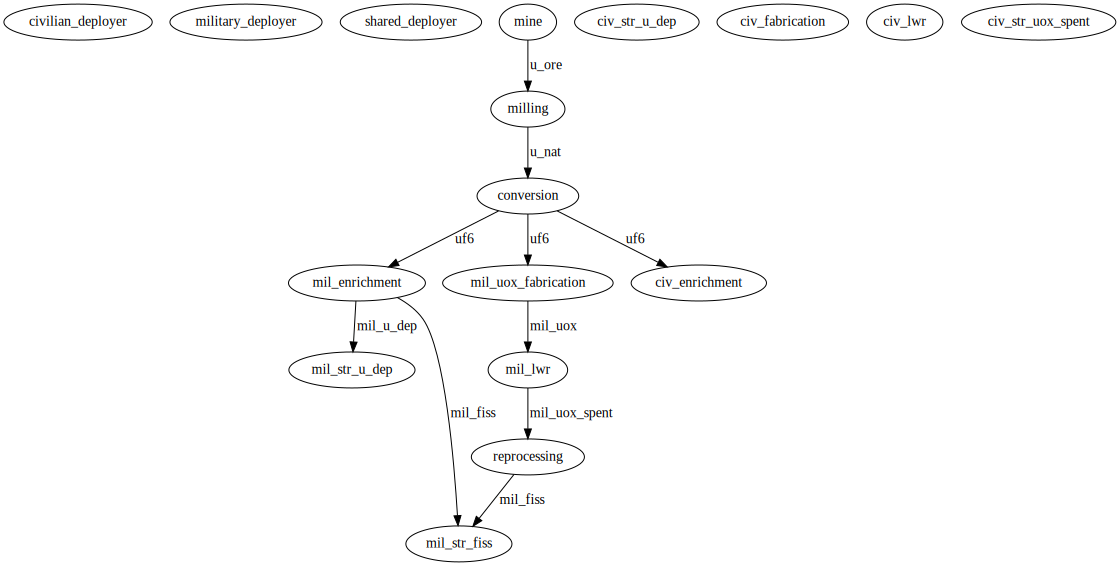

In [4]:
cgr.flow_graph(evaler=ev_, label='com', stop=121)


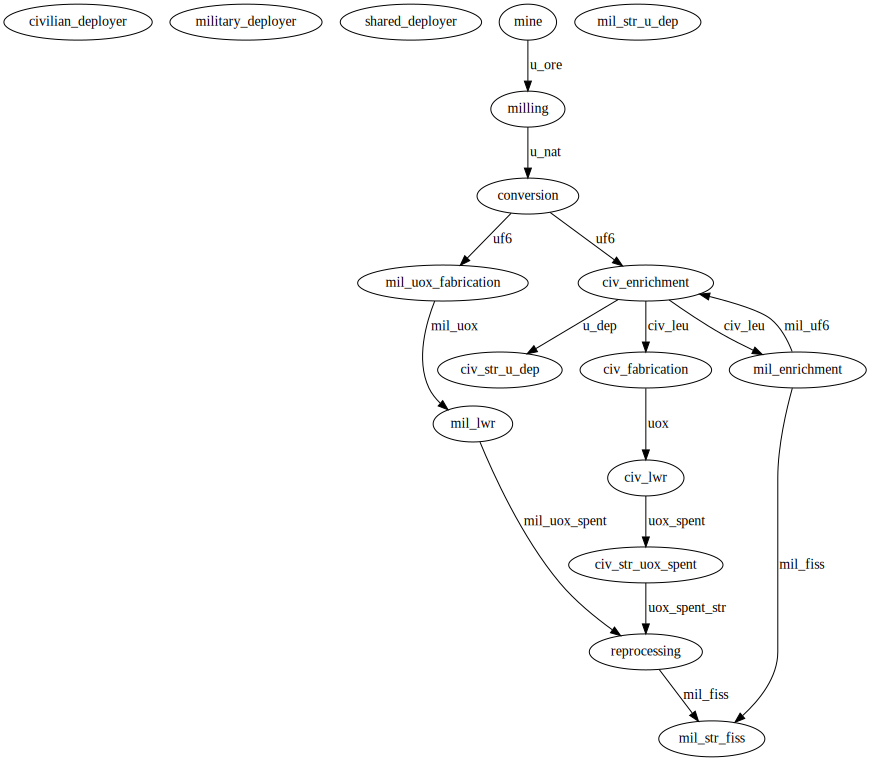

In [5]:
cgr.flow_graph(evaler=ev_, label='com', start=122)



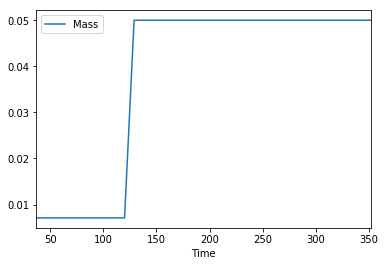

In [6]:
cyh.TransFrac(ev=ev_, rec=['mil_enrichment'], nucs2=['235U'], nucs1=['238U']).dropna().plot(x='Time', y='Mass')


array([<matplotlib.axes._subplots.AxesSubplot object at 0x12ae593c8>],
      dtype=object)

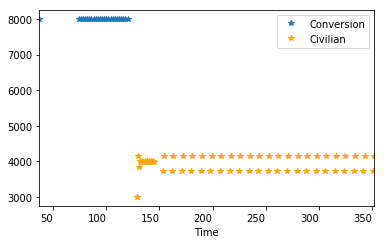

In [7]:
trans_mil_enrich_conversion = cyh.Trans(ev=ev_, send=['conversion'],rec=['mil_enrichment']).dropna()
trans_mil_enrich_conversion = trans_mil_enrich_conversion[trans_mil_enrich_conversion['Mass'] != 0]
trans_mil_enrich_civ = cyh.Trans(ev=ev_, send=['civ_enrichment'],rec=['mil_enrichment']).dropna()
trans_mil_enrich_civ = trans_mil_enrich_civ[trans_mil_enrich_civ['Mass'] != 0]

ax = trans_mil_enrich_conversion.plot(subplots=True, x='Time', y='Mass', label='Conversion', style='*')
trans_mil_enrich_civ.plot(subplots=True, color='orange', x='Time', y='Mass', ax=ax, label='Civilian', style='*')


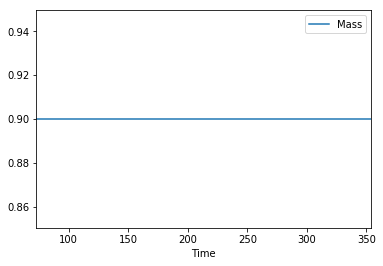

In [8]:
cyh.TransFrac(ev=ev_, send=['mil_enrichment'], rec=['mil_str_fiss'], nucs2=['235U'], nucs1=['238U']).dropna().plot(x='Time', y='Mass')



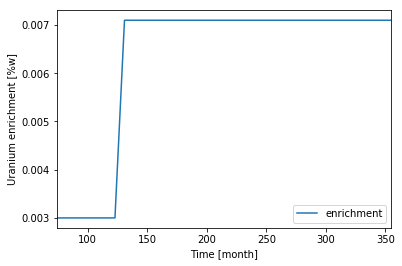

In [9]:
mil_feed_enrich = cyh.TransFrac(ev=ev_, send=['mil_enrichment'], rec=['mil_str_u_dep','civ_enrichment'], nucs2=['235U'], nucs1=['238U']).dropna()
mil_feed_enrich.plot(x='Time', y='Mass', label='enrichment')
plt.ylabel('Uranium enrichment [%w]')
plt.xlabel('Time [month]')

array([<matplotlib.axes._subplots.AxesSubplot object at 0x12b0b5f60>],
      dtype=object)

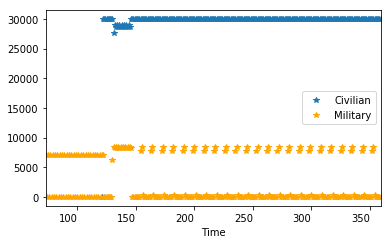

In [10]:
SWU_civ = SWU(ev_, facilities=['civ_enrichment'])
SWU_mil = SWU(ev_, facilities=['mil_enrichment'])

ax = SWU_civ[SWU_civ['Value']<1e50].plot(subplots=True, x='Time', y='Value', style='*', label='Civilian')
SWU_mil[SWU_mil['Value']<1e50].plot(subplots=True, ax=ax, x='Time', y='Value', style='*', color='orange', label='Military')

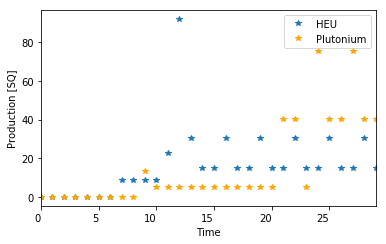

In [11]:
heu_prod = tm.transactions(ev_, senders = ['mil_enrichment'], receivers=['mil_str_fiss'])
heu_prod['Mass'] *= 1/25.
ax = cyh.month2year(heu_prod, 1, 12).plot(subplots=True, x='Time', y='Mass', style='*', label = 'HEU')


pu_prod = tm.transactions(ev_, senders=['reprocessing'], receivers=['mil_str_fiss'])
pu_prod['Mass'] *= 1/8.
cyh.month2year(pu_prod, 1, 12).plot(subplots=True, color='orange', ax = ax, x='Time', y='Mass', style='*', label='Plutonium')

plt.ylabel('Production [SQ]')


/Users/mouginot/.local/lib/python3.5/site-packages/cymetric/timeseries.py:205: UserWarning: no faciity provided
  warnings.warn(wng_msg, UserWarning)


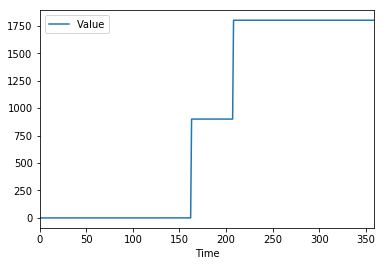

In [12]:
tm.get_power(ev_).plot(x='Time', y='Value')

In [15]:
file_b = "cycle_div_b/main.sqlite"
db_b = cym.dbopen(file_b)
ev_b = cym.Evaluator(db=db_b, write=False)



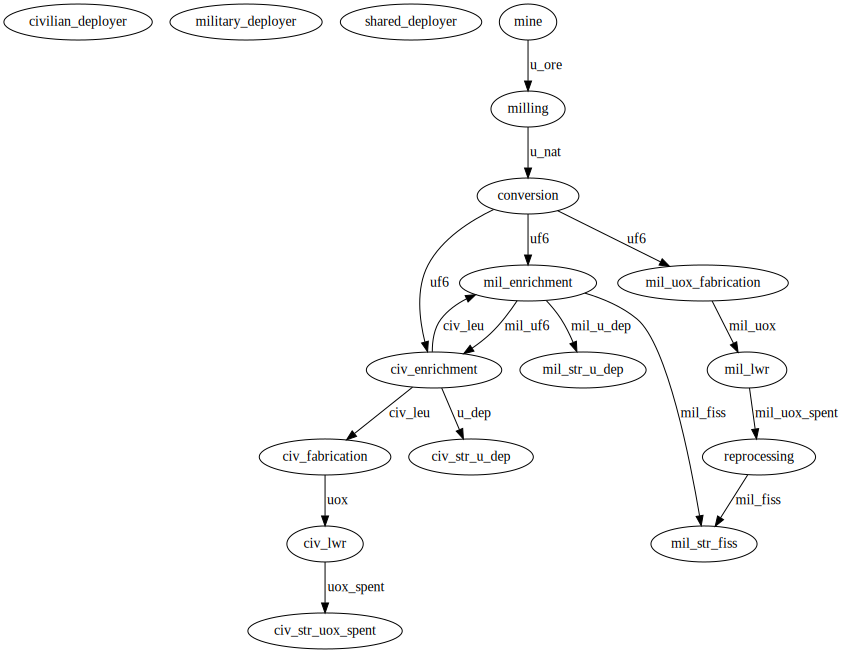

In [16]:
cgr.flow_graph(evaler=ev_b, label='com')



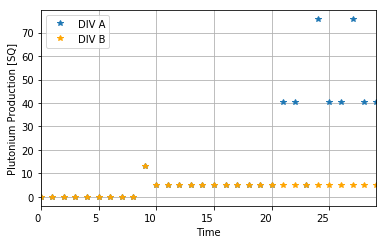

In [20]:

ax = cyh.month2year(pu_prod, 1, 12).plot(subplots=True, x='Time', y='Mass', style='*', label = 'DIV A')


pu_prod_b = tm.transactions(ev_b, senders=['reprocessing'], receivers=['mil_str_fiss'])
pu_prod_b['Mass'] *= 1/8.
cyh.month2year(pu_prod_b, 1, 12).plot(subplots=True, color='orange', ax = ax, x='Time', y='Mass', style='*', label='DIV B')

plt.ylabel('Plutonium Production [SQ]')
plt.grid()